# Spot the spots

## Introduction to Machine Learning on NeSI Workshop

This notebook shows how machine learning can be applied to feature detection. You're faced with the tedious task of counting "spots" present in a large number of data samples. The spots may represent pictures of fishes, tropical cyclones, skin moles, tumours or black holes - you choose.

*In this version the number of spots are classified into separate categories.*

## Requirements

You will need:
    
 * Python 3
 * NumPy
 * Matplotlib
 * TensorFlow 2.0

## Input parameters for the dataset

In [1]:
# dataset input values - feel free to change
numTrain = 1000     # number of training samples
numTest = 100      # number of testing samples
numCells = 40      # the data have size numCells x numCells
maxNumSpots = 5    # the maximum number of spots 0...maxNumSpots
categories = ['<=1', '==2', '==3', '>=4'] # classification categories (1 spot or less, 2 spots, etc.)

## Reproducible results for testing the model

Setting the random seeds ensures you will get the same results when running this notebook from the start (Restart and Run All). Feel free change the seed value or comment out this block to test your model on different data.

In [2]:
random_seed = 123

import numpy as np
np.random.seed(random_seed)

import tensorflow as tf
tf.random.set_seed(random_seed)

import random
random.seed(random_seed)

## Where the code will run

Uncomment these commands to show what devices are available and are being used.

In [3]:
# list available GPUs
#tf.config.experimental.list_physical_devices()

In [4]:
# print info about which device operations are running on
#tf.debugging.set_log_device_placement(True)

## Some convenience functions

### Function to generate random samples

Each sample is a 2d image/data with spots at random locations.

In [5]:
# define the 2d grid
xs = np.linspace(0., 1., numCells)
ys = np.linspace(0., 1., numCells)
xxs, yys = np.meshgrid(xs, ys)

def generateRandomSamples(numSamples):
    """
    Generate samples containing random data with spots (Gaussian field over zero background)
    @param numSamples number of samples to generate
    @return samplesInput array containing data for the samples
    @return samplesOutput vector with the correct number of spots in each sample
    
    """
    # allocate memory
    samplesInput = np.zeros((numSamples, numCells, numCells), np.float32)
    samplesOutput = np.zeros((numSamples,), np.int8)
    # create the samples
    for sample in range(numSamples):
        numSpots = int(maxNumSpots * np.random.random() + 0.5)
        data = samplesInput[sample, ...]
        for i in range(numSpots):
            # random radius
            rad = 0.1 + 0.0*np.random.random()  # currently fixed radius of 0.1
            # random location
            x0, y0 = 0.1 + 0.8*np.random.random(), 0.1 + 0.8*np.random.random()
            data += np.exp( -((xxs - x0)**2 + (yys - y0)**2)/rad**2 )
        # normalize, filter nans
        maxVal = data.max()
        if maxVal != 0:
            data /= maxVal
        data = np.nan_to_num(data)
        # map the number of spots to one of our categories (classIndex is 
        # in the range 0...len(categories) - 1)
        classIndex = [eval(f'{numSpots}' + c) for c in categories].index(True)
        samplesOutput[sample] = classIndex
  
    return samplesInput, samplesOutput

### Function to plot the data

In [8]:
import matplotlib.pylab as plt

numCols = 5
def plotData(iBeg, iEnd, dataInput, dataOutput, dataReferenceOutput=[]):
    """
    Plot the data
    @param iBeg start index in the dataset (list of 2D data)
    @param iEnd one past the last index in the dataset
    @param dataInput dataset
    @param dataOutput number of spots for each data array
    @param dataReferenceOutput correct number of spots for each data array
  
    """
    numPlots = iEnd - iBeg
    numRows = numPlots // numCols
    if numPlots % numCols > 0:
        numRows += 1
    for i in range(iBeg, iEnd):
        plt.subplot(numRows, numCols, i - iBeg + 1)
        plt.imshow(dataInput[i, ...], cmap='YlOrBr')
        plt.axis('off')
        txt = f'{categories[dataOutput[i]]}'
        if len(dataReferenceOutput) > 0:
            txt += f' (ex {dataReferenceOutput[i]})'
        plt.title(txt, fontsize=8)
    plt.show()

## Creating the training samples

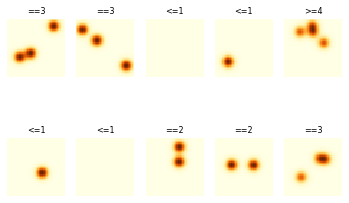

In [9]:
trainInput, trainOutput = generateRandomSamples(numTrain)
plotData(0, min(10, numTrain), trainInput, trainOutput)  # plotting a subset of the training dataset

## Creating the test samples

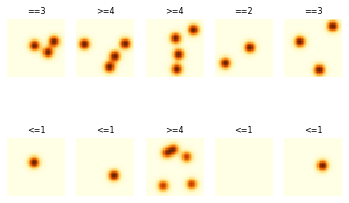

In [10]:
testInput, testOutput = generateRandomSamples(numTest)
plotData(0, min(10, numTest), testInput, testOutput)  # plotting a subset of the testing dataset

## Creating a neural network

In [11]:
from tensorflow import keras

# build the neural network
model = keras.Sequential()

# first layer - looking at fine details
model.add( keras.layers.Conv2D(8, kernel_size=(3,3), strides=(1,1),
                             padding='same', data_format='channels_last',
                             activation='relu') )
model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)) )  # which filter most successful in identifying certain feature

# second layer - looking at coarser details...
model.add( keras.layers.Conv2D(8, kernel_size=(3,3), strides=(1,1),
                             padding='same', data_format='channels_last',
                             activation='relu') )
model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)) ) # pool size

# add a dense layer with linear regression
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dense(len(categories), activation='softmax') )  # as many outputs as there are categories
# could have mapped into an array (output), max num spots elements, output is probability of each number spots

# configure the model for training
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training the neural network

The input is a 4d tensor which should have shape (samples, rows, cols, channels) since we specified "channels_last" as the data format above. Thus we have to reshape our 3d array to add a channel dimension.

In [12]:
numEpochs = 20
history = model.fit(trainInput.reshape(-1, numCells, numCells, 1),
                    trainOutput, epochs=numEpochs, validation_split=0.3)

Train on 700 samples, validate on 300 samples
Epoch 1/20
700/700 [==============================] - 1s 2ms/sample - loss: 1.3191 - accuracy: 0.3414 - val_loss: 1.3154 - val_accuracy: 0.3900
Epoch 2/20
700/700 [==============================] - 0s 422us/sample - loss: 1.2720 - accuracy: 0.3871 - val_loss: 1.3090 - val_accuracy: 0.3767
Epoch 3/20
700/700 [==============================] - 0s 417us/sample - loss: 1.2536 - accuracy: 0.3929 - val_loss: 1.2972 - val_accuracy: 0.3633
Epoch 4/20
700/700 [==============================] - 0s 418us/sample - loss: 1.2416 - accuracy: 0.3986 - val_loss: 1.2950 - val_accuracy: 0.3633
Epoch 5/20
700/700 [==============================] - 0s 417us/sample - loss: 1.2266 - accuracy: 0.4157 - val_loss: 1.2969 - val_accuracy: 0.3733
Epoch 6/20
700/700 [==============================] - 0s 421us/sample - loss: 1.2147 - accuracy: 0.4229 - val_loss: 1.2889 - val_accuracy: 0.3867
Epoch 7/20
700/700 [==============================] - 0s 417us/sample - loss: 1.

## Plotting the model performance

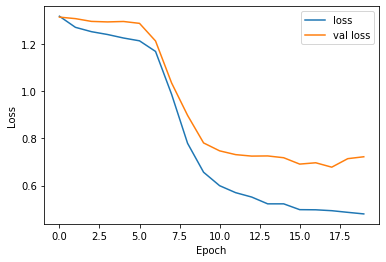

In [13]:
# plot the loss against epoch
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

## Summary of the model

In [14]:
# give a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3204      
Total params: 3,868
Trainable params: 3,868
Non-trainable params: 0
______________________________________________________

## Predicting the the number of spots in each test sample

In [16]:
predictionProbs = model.predict(testInput.reshape(-1, numCells, numCells, 1))
predClassInds = np.argmax(predictionProbs, axis=1)
# compute the errors: difference between predictions and testOuput
errors = predClassInds - testOutput
numErrors = (errors != 0).sum()
print(errors)
print(f'num errors = {numErrors} ({100*numErrors/numTest} %)')

[ 0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0 -2
  0  0 -1  0  0  0  0  1  0  0 -1  1  0  0  1  0  0  0  0  0  0  0 -1  0
 -1  0  0  0  0 -2 -1  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  1  0
  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0
  0  1  0  0]
num errors = 20 (20.0 %)



Plotting datasets for which the predictions were wrong

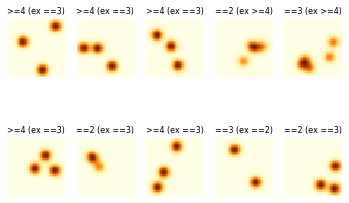

In [17]:
inds = np.nonzero(errors != 0)[0]
failuresInput = testInput[inds, :]
failuresOutput = predClassInds[inds]
correctOutput = [categories[i] for i in testOutput[inds]]
numFailures = len(failuresOutput)
plotData(0, min(10, numFailures), failuresInput, failuresOutput, correctOutput)

## Exercise

Try to improve our initial model. Feel free to change anything above, such as:

* parameters for the layers (convolution, pooling, dense - see for example the [convolution layers documentation](https://keras.io/layers/convolutional/))
  - number of filters, kernel size, stride, etc.
* add or remove layers (e.g. convolution, pooling, dense layers)
* adjust other parameters, e.g. the size of the input dataset

See if you can reduce the error.

Once you have improved improved your model, try changing the random seed and see if the behaviour changes.